<a href="https://colab.research.google.com/github/woogunny/BREAST-ULTRASOUND-IMAGES-DEEP-LEARNING-CLASSIFICATION-/blob/main/cookie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pwd

'/content'

In [ ]:
pip install numpy

In [ ]:
pip install pandas

In [ ]:
pip argparse

In [ ]:
pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0

In [ ]:
pip list

In [ ]:
pip install seaborn

In [ ]:
pip install tensorflow

In [ ]:
pip install scikit-learn

In [ ]:
pip install tqdm

In [ ]:
pip install matplotlib

In [ ]:
pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
# import random
# from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.math import confusion_matrix
# import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
# tf.random.set_seed(3)
from PIL import Image
from torchvision import transforms
import torch
from torch.utils.data import Dataset
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.utils import make_grid


import argparse

In [ ]:
#dataset

class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.classes = sorted(os.listdir(directory))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []

        for class_name in self.classes:
            class_dir = os.path.join(self.directory, class_name)
            for image_name in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, image_name), self.class_to_idx[class_name]))


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# model

def get_model(name, n_class, pretrained=True):
    if name == "vgg16":
        model = models.vgg16(pretrained=pretrained)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, n_class)
    elif name == "resnet":
        model = models.resnet18(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, n_class)
    return model

class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d(200)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(256*200*200, 3)  # Adaptive Pooling 이후의 출력 크기에 맞춰 조정

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.relu(self.conv4(x))
        x = self.adaptive_pool(x)
        x = x.view(-1, 256*200*200)  # 적절한 크기로 플래트닝
        x = self.fc(x)
        return x



In [ ]:
#utils

def visualize_batch(data_loader, class_names):
    images, labels = next(iter(data_loader))
    img_grid =make_grid(images, nrow=8)
    npimg=img_grid.numpy()

    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Dataset Visualization')

    labels=[class_names[label] for label in labels]
    for i, label in enumerate(labels):

        x= (i%8 + 0.5) /8
        y= (i // 8)/ (len(labels) / 8)
        plt.text(x, y, label, ha='center', va='bottom', transform=plt.gca().transAxes, color='white')

    plt.axis('off')
    plt.show()

In [ ]:
#train
from torch.optim.lr_scheduler import MultiStepLR, StepLR

def train_model(model, train_loader, epochs, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = MultiStepLR(optimizer, [5,10],gamma=0.1)

    # if args.scheduler == 'multistep':
    #     scheduler = MultiStepLR(optimizer, [5,10],gamma=0.1)
    # elif arg.scheduler == 'steplr':
    #     scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)
        correct_predictions = 0
        total_predictions = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()


        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_predictions
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        scheduler.step()

    print("Finished Training")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), loss_history, label='Avg Loss per Epoch')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), accuracy_history, label='Accuracy per Epoch')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

    torch.save(model.state_dict(), f"./model_weight_2d.pth")

In [ ]:
#evaluate
from tqdm import tqdm

def evaluate_model(model, test_loader, device):

    # 모델 가중치 로드
    model.load_state_dict(torch.load(model_weight_2d.pth, map_location=device))

    model.eval()

    criterion = nn.CrossEntropyLoss()

    total = 0
    correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)

    accuracy = correct / total * 100

    print(f'Test Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}')


    return accuracy, avg_loss



Start Code
My model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
         MaxPool2d-2         [-1, 64, 112, 112]               0
            Conv2d-3        [-1, 128, 112, 112]          73,856
         MaxPool2d-4          [-1, 128, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]         295,168
         MaxPool2d-6          [-1, 256, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         590,080
              ReLU-8          [-1, 256, 28, 28]               0
 AdaptiveAvgPool2d-9        [-1, 256, 200, 200]               0
           Linear-10                    [-1, 3]      30,720,003
Total params: 31,680,899
Trainable params: 31,680,899
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 134.78
Params

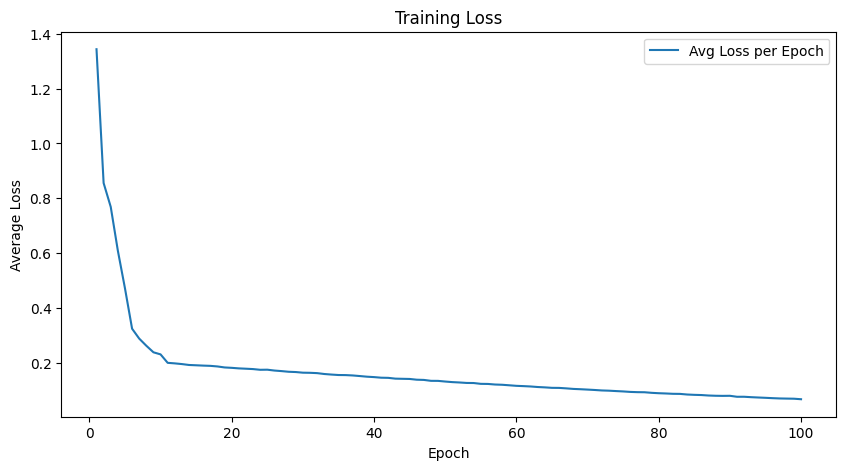

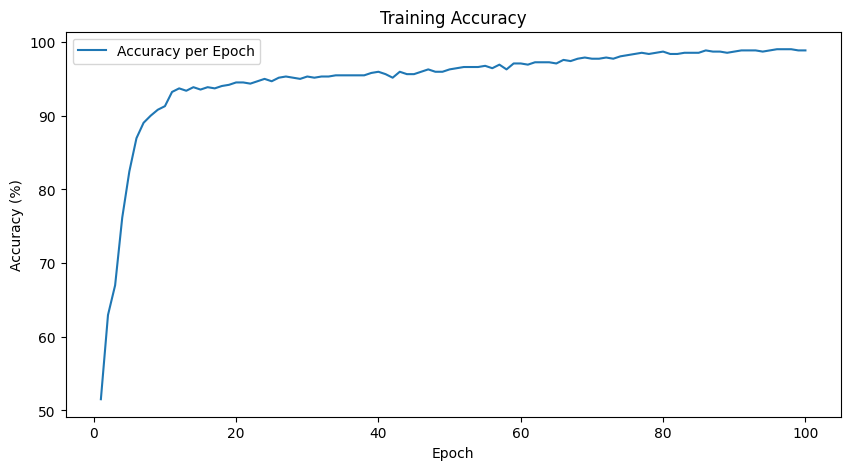

In [ ]:
#main()

# from augment import*
# from evaluate import*

def main():


  print("Start Code")
  print("My model")

  model = Simple2DCNN()
  summary(model.cuda(), (3,224,224))

  transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
  ])
  train_dataset = ImageDataset(directory='drive/MyDrive/train',transform=transform)
  test_dataset = ImageDataset(directory='drive/MyDrive/test',transform=transform)

  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  # dataiter = iter(train_loader)
  # data_loader, labels = dataiter.next()
  # visualize_audio_batch(data_loader, labels)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  train_model(model, train_loader, epochs=100, device=device)
  # evaluate_model(model, test_loader, device=device)

main()